<a href="https://colab.research.google.com/github/Madhuraupadhye/Speaker-Recognition--Dynamic-Catalyst-MU-/blob/main/Real_life_Data_Analysis_SR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import shutil
import numpy as np
import tensorflow as tf
import keras


from pathlib import Path
from IPython.display import display, Audio

In [ ]:
!kaggle datasets download -d madhuraupadhye/iemocap-dataset
!unzip -qq iemocap-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/madhuraupadhye/iemocap-dataset
License(s): unknown
 97% 190M/195M [00:02<00:00, 74.6MB/s]
100% 195M/195M [00:02<00:00, 84.0MB/s]


In [ ]:
DATASET_ROOT = "IEMOCAP Dataset"

AUDIO_SUBFOLDER = "audio"
NOISE_SUBFOLDER = "noise"

DATASET_AUDIO_PATH = os.path.join(DATASET_ROOT, AUDIO_SUBFOLDER)
DATASET_NOISE_PATH = os.path.join(DATASET_ROOT, NOISE_SUBFOLDER)

VALID_SPLIT = 0.1
SHUFFLE_SEED = 43
SAMPLING_RATE = 16000
SCALE = 0.5
BATCH_SIZE = 128
EPOCHS = 2

In [ ]:
for folder in os.listdir(DATASET_ROOT):
    if os.path.isdir(os.path.join(DATASET_ROOT, folder)):
        if folder in [AUDIO_SUBFOLDER, NOISE_SUBFOLDER]:
            continue
        elif folder in ["other", "_background_noise_"]:
            shutil.move(
                os.path.join(DATASET_ROOT, folder),
                os.path.join(DATASET_NOISE_PATH, folder),
            )
        else:
            shutil.move(
                os.path.join(DATASET_ROOT, folder),
                os.path.join(DATASET_AUDIO_PATH, folder),
            )

In [ ]:
def list_directories(path):
    return [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]

audio_directories = list_directories(DATASET_AUDIO_PATH)
noise_directories = list_directories(DATASET_NOISE_PATH)

print(f"Directories in {DATASET_AUDIO_PATH}: {audio_directories}")
print(f"Directories in {DATASET_NOISE_PATH}: {noise_directories}")

assert all(folder not in ["other", "_background_noise_"] for folder in audio_directories), "Noise directories found in audio folder!"
assert all(folder in ["other", "_background_noise_"] for folder in noise_directories), "Non-noise directories found in noise folder!"

print("Directories have been successfully separated.")

Directories in IEMOCAP Dataset/audio: ['Speaker 3', 'Speaker 1', 'Speaker 2', 'Speaker 4']
Directories in IEMOCAP Dataset/noise: ['other', '_background_noise_']
Directories have been successfully separated.


In [ ]:
noise_paths = []
for subdir in os.listdir(DATASET_NOISE_PATH):
    subdir_path = Path(DATASET_NOISE_PATH) / subdir
    if os.path.isdir(subdir_path):
        noise_paths += [
            os.path.join(subdir_path, filepath)
            for filepath in os.listdir(subdir_path)
            if filepath.endswith(".wav")
        ]
if not noise_paths:
    raise RuntimeError(f"Could not find any files at {DATASET_NOISE_PATH}")
print(
    "Found {} files belonging to {} directories".format(
        len(noise_paths), len(os.listdir(DATASET_NOISE_PATH))
    )
)

Found 6 files belonging to 2 directories


In [ ]:
command = (
    "for dir in `ls -1 " + DATASET_NOISE_PATH + "`; do "
    "for file in `ls -1 " + DATASET_NOISE_PATH + "/$dir/*.wav`; do "
    "sample_rate=`ffprobe -hide_banner -loglevel panic -show_streams "
    "$file | grep sample_rate | cut -f2 -d=`; "
    "if [ $sample_rate -ne 16000 ]; then "
    "ffmpeg -hide_banner -loglevel panic -y "
    "-i $file -ar 16000 temp.wav; "
    "mv temp.wav $file; "
    "fi; done; done"
)
os.system(command)

def load_noise_sample(path):
    sample, sampling_rate = tf.audio.decode_wav(
        tf.io.read_file(path), desired_channels=1
    )
    if sampling_rate == SAMPLING_RATE:
        # Number of slices of 16000 each that can be generated from the noise sample
        slices = int(sample.shape[0] / SAMPLING_RATE)
        sample = tf.split(sample[: slices * SAMPLING_RATE], slices)
        return sample
    else:
        print("Sampling rate for {} is incorrect. Ignoring it".format(path))
        return None


noises = []
for path in noise_paths:
    sample = load_noise_sample(path)
    if sample:
        noises.extend(sample)
noises = tf.stack(noises)

print(
    "{} noise files were split into {} noise samples where each is {} sec. long".format(
        len(noise_paths), noises.shape[0], noises.shape[1] // SAMPLING_RATE
    )
)

6 noise files were split into 354 noise samples where each is 1 sec. long


In [ ]:
def load_audio_sample(path):
    sample, sampling_rate = tf.audio.decode_wav(
        tf.io.read_file(path), desired_channels=1
    )
    if sampling_rate == SAMPLING_RATE:
        # Number of slices of 16000 each that can be generated from the audio sample
        slices = int(sample.shape[0] / SAMPLING_RATE)
        if slices > 0: # Check if there are any slices to make
            sample = tf.split(sample[: slices * SAMPLING_RATE], slices)
            return sample
        else:
            print(f"Sample at {path} is too short. Ignoring it.")
            return None
    else:
        print("Sampling rate for {} is incorrect. Ignoring it".format(path))
        return None

In [ ]:
def paths_and_labels_to_dataset(audio_paths, labels):
    """Constructs a dataset of audios and labels."""
    path_ds = tf.data.Dataset.from_tensor_slices(audio_paths)
    audio_ds = path_ds.map(
        lambda x: path_to_audio(x), num_parallel_calls=tf.data.AUTOTUNE
    )
    label_ds = tf.data.Dataset.from_tensor_slices(labels)
    return tf.data.Dataset.zip((audio_ds, label_ds))


def path_to_audio(path):
    """Reads and decodes an audio file."""
    audio = tf.io.read_file(path)
    audio, _ = tf.audio.decode_wav(audio, 1, SAMPLING_RATE)
    return audio


def add_noise(audio, noises=None, scale=0.5):
    if noises is not None:
        # Create a random tensor of the same size as audio ranging from
        # 0 to the number of noise stream samples that we have.
        tf_rnd = tf.random.uniform(
            (tf.shape(audio)[0],), 0, noises.shape[0], dtype=tf.int32
        )
        noise = tf.gather(noises, tf_rnd, axis=0)

        # Get the amplitude proportion between the audio and the noise
        prop = tf.math.reduce_max(audio, axis=1) / tf.math.reduce_max(noise, axis=1)
        prop = tf.repeat(tf.expand_dims(prop, axis=1), tf.shape(audio)[1], axis=1)

        # Adding the rescaled noise to audio
        audio = audio + noise * prop * scale

    return audio


def audio_to_fft(audio):
    # Since tf.signal.fft applies FFT on the innermost dimension,
    # we need to squeeze the dimensions and then expand them again
    # after FFT
    audio = tf.squeeze(audio, axis=-1)
    fft = tf.signal.fft(
        tf.cast(tf.complex(real=audio, imag=tf.zeros_like(audio)), tf.complex64)
    )
    fft = tf.expand_dims(fft, axis=-1)

    # Return the absolute value of the first half of the FFT
    # which represents the positive frequencies
    return tf.math.abs(fft[:, : (audio.shape[1] // 2), :])


# Get the list of audio file paths along with their corresponding labels

class_names = os.listdir(DATASET_AUDIO_PATH)
print(
    "Our class names: {}".format(
        class_names,
    )
)

audio_paths = []
labels = []
for label, name in enumerate(class_names):
    print(
        "Processing speaker {}".format(
            name,
        )
    )
    dir_path = Path(DATASET_AUDIO_PATH) / name
    speaker_sample_paths = [
        os.path.join(dir_path, filepath)
        for filepath in os.listdir(dir_path)
        if filepath.endswith(".wav")
    ]
    audio_paths += speaker_sample_paths
    labels += [label] * len(speaker_sample_paths)

print(
    "Found {} files belonging to {} classes.".format(len(audio_paths), len(class_names))
)

# Shuffle
rng = np.random.RandomState(SHUFFLE_SEED)
rng.shuffle(audio_paths)
rng = np.random.RandomState(SHUFFLE_SEED)
rng.shuffle(labels)

# Split into training and validation
num_val_samples = int(VALID_SPLIT * len(audio_paths))
print("Using {} files for training.".format(len(audio_paths) - num_val_samples))
train_audio_paths = audio_paths[:-num_val_samples]
train_labels = labels[:-num_val_samples]

print("Using {} files for validation.".format(num_val_samples))
valid_audio_paths = audio_paths[-num_val_samples:]
valid_labels = labels[-num_val_samples:]

# Create 2 datasets, one for training and the other for validation
train_ds = paths_and_labels_to_dataset(train_audio_paths, train_labels)
train_ds = train_ds.shuffle(buffer_size=BATCH_SIZE * 8, seed=SHUFFLE_SEED).batch(
    BATCH_SIZE
)

valid_ds = paths_and_labels_to_dataset(valid_audio_paths, valid_labels)
valid_ds = valid_ds.shuffle(buffer_size=32 * 8, seed=SHUFFLE_SEED).batch(32)


# Add noise to the training set
train_ds = train_ds.map(
    lambda x, y: (add_noise(x, noises, scale=SCALE), y),
    num_parallel_calls=tf.data.AUTOTUNE,
)

# Transform audio wave to the frequency domain using `audio_to_fft`
train_ds = train_ds.map(
    lambda x, y: (audio_to_fft(x), y), num_parallel_calls=tf.data.AUTOTUNE
)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

valid_ds = valid_ds.map(
    lambda x, y: (audio_to_fft(x), y), num_parallel_calls=tf.data.AUTOTUNE
)
valid_ds = valid_ds.prefetch(tf.data.AUTOTUNE)

Our class names: ['Speaker 3', 'Speaker 1', 'Speaker 2', 'Speaker 4']
Processing speaker Speaker 3
Processing speaker Speaker 1
Processing speaker Speaker 2
Processing speaker Speaker 4
Found 1750 files belonging to 4 classes.
Using 1575 files for training.
Using 175 files for validation.


In [ ]:

def residual_block(x, filters, conv_num=3, activation="relu"):
    s = keras.layers.Conv1D(filters, 1, padding="same")(x)
    for i in range(conv_num - 1):
        x = keras.layers.Conv1D(filters, 3, padding="same")(x)
        x = keras.layers.Activation(activation)(x)
    x = keras.layers.Conv1D(filters, 3, padding="same")(x)
    x = keras.layers.Add()([x, s])
    x = keras.layers.Activation(activation)(x)
    return keras.layers.MaxPool1D(pool_size=2, strides=2)(x)


def build_model(input_shape, num_classes):
    inputs = keras.layers.Input(shape=input_shape, name="input")

    x = residual_block(inputs, 16, 2)
    x = residual_block(x, 32, 2)
    x = residual_block(x, 64, 3)
    x = residual_block(x, 128, 3)
    x = residual_block(x, 128, 3)


    x = keras.layers.AveragePooling1D(pool_size=3, strides=3)(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(256, activation="relu")(x)
    x = keras.layers.Dense(128, activation="relu")(x)

    outputs = keras.layers.Dense(num_classes, activation="softmax", name="output")(x)

    return keras.models.Model(inputs=inputs, outputs=outputs)


model = build_model((SAMPLING_RATE // 2, 1), len(class_names))

model.summary()

# Compile the model using Adam's default learning rate
model.compile(
    optimizer="Adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

# Add callbacks:
# 'EarlyStopping' to stop training when the model is not enhancing anymore
# 'ModelCheckPoint' to always keep the model that has the best val_accuracy
model_save_filename = "model.keras"

earlystopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
mdlcheckpoint_cb = keras.callbacks.ModelCheckpoint(
    model_save_filename, monitor="val_accuracy", save_best_only=True
)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 8000, 1)]            0         []                            
                                                                                                  
 conv1d_1 (Conv1D)           (None, 8000, 16)             64        ['input[0][0]']               
                                                                                                  
 activation (Activation)     (None, 8000, 16)             0         ['conv1d_1[0][0]']            
                                                                                                  
 conv1d_2 (Conv1D)           (None, 8000, 16)             784       ['activation[0][0]']          
                                                                                              

In [ ]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=valid_ds,
    callbacks=[earlystopping_cb, mdlcheckpoint_cb],
)

Epoch 1/2
13/13 [==============================] - 107s 8s/step - loss: 0.1505 - accuracy: 0.9505 - val_loss: 1.2937 - val_accuracy: 0.7543
Epoch 2/2
13/13 [==============================] - 108s 8s/step - loss: 0.1303 - accuracy: 0.9505 - val_loss: 1.2465 - val_accuracy: 0.7943


In [ ]:
print(model.evaluate(valid_ds))

6/6 [==============================] - 4s 614ms/step - loss: 1.2465 - accuracy: 0.7943
[1.2464802265167236, 0.7942857146263123]


In [ ]:
SAMPLES_TO_DISPLAY = 10

test_ds = paths_and_labels_to_dataset(valid_audio_paths, valid_labels)
test_ds = test_ds.shuffle(buffer_size=BATCH_SIZE * 8, seed=SHUFFLE_SEED).batch(
    BATCH_SIZE
)

test_ds = test_ds.map(
    lambda x, y: (add_noise(x, noises, scale=SCALE), y),
    num_parallel_calls=tf.data.AUTOTUNE,
)
correct_predictions = 0

for audios, labels in test_ds.take(1):
    # Get the signal FFT
    ffts = audio_to_fft(audios)
    # Predict
    y_pred = model.predict(ffts)
    # Take random samples
    rnd = np.random.randint(0, BATCH_SIZE, SAMPLES_TO_DISPLAY)
    audios = audios.numpy()[rnd, :, :]
    labels = labels.numpy()[rnd]
    y_pred = np.argmax(y_pred, axis=-1)[rnd]

    for index in range(SAMPLES_TO_DISPLAY):
        print(
            "Speaker:\33{} {}\33[0m\tPredicted:\33{} {}\33[0m".format(
                "[92m" if labels[index] == y_pred[index] else "[91m",
                class_names[labels[index]],
                "[92m" if labels[index] == y_pred[index] else "[91m",
                class_names[y_pred[index]],
            )
        )
        if labels[index] == y_pred[index]:
            correct_predictions += 1
        display(Audio(audios[index, :, :].squeeze(), rate=SAMPLING_RATE))

accuracy = correct_predictions / SAMPLES_TO_DISPLAY
print(f"Accuracy: {accuracy * 100:.2f}%")

4/4 [==============================] - 2s 436ms/step
Speaker: Speaker 3	Predicted: Speaker 3


Speaker: Speaker 4	Predicted: Speaker 4


Speaker: Speaker 1	Predicted: Speaker 1


Speaker: Speaker 3	Predicted: Speaker 3


Speaker: Speaker 4	Predicted: Speaker 3


Speaker: Speaker 2	Predicted: Speaker 2


Speaker: Speaker 3	Predicted: Speaker 3


Speaker: Speaker 3	Predicted: Speaker 3


Speaker: Speaker 3	Predicted: Speaker 3


Speaker: Speaker 2	Predicted: Speaker 2


Accuracy: 90.00%


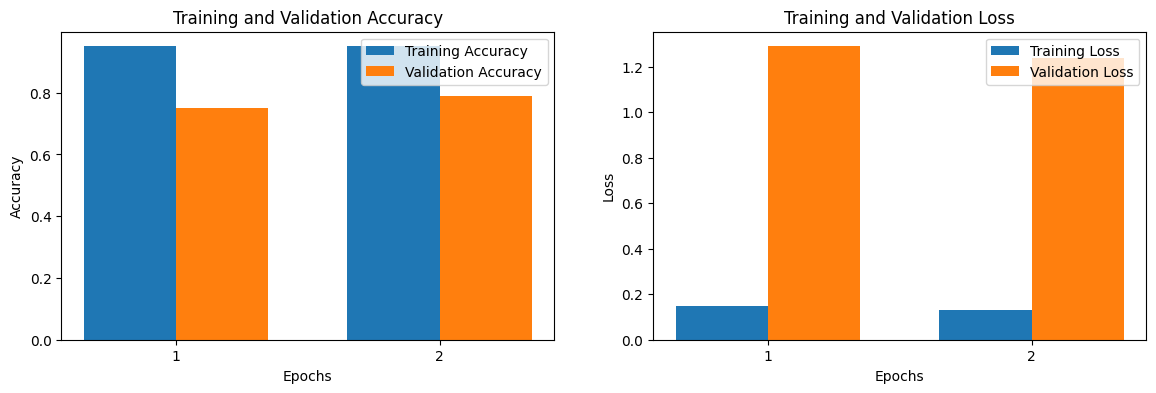

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Example data
epochs = [1, 2]
train_accuracy = [0.95, 0.95]
val_accuracy = [0.75, 0.79]
train_loss = [0.15, 0.13]
val_loss = [1.29, 1.24]

# Plot accuracy
plt.figure(figsize=(14, 4))

plt.subplot(1, 2, 1)
bar_width = 0.35
index = np.arange(len(epochs))

plt.bar(index, train_accuracy, bar_width, label='Training Accuracy')
plt.bar(index + bar_width, val_accuracy, bar_width, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.xticks(index + bar_width / 2, epochs)
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.bar(index, train_loss, bar_width, label='Training Loss')
plt.bar(index + bar_width, val_loss, bar_width, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.xticks(index + bar_width / 2, epochs)
plt.legend()

# Display the plots
plt.show()